In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = 'data/BMP_Multi/'
sz = 60
arch=resnet50
bs = 64

In [4]:
label_csv = f'{PATH}bmp_test.csv'

In [5]:
BMPS = 'train'

In [6]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO)
data = ImageClassifierData.from_csv(PATH,BMPS, label_csv, tfms=tfms, bs=bs)

In [7]:
#Set aside cross validation of 20%
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [8]:
fn = PATH + data.trn_ds.fnames[0]

In [9]:
fns_trn = [PATH + i for i in data.trn_ds.fnames]

aug_tfms = RandomRotate(90, p=0.75, mode=cv2.BORDER_REFLECT, tfm_y=TfmType.NO), 
RandomLighting(b=0.5, c=0, tfm_y=TfmType.NO)

In [10]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms = [RandomRotate(90, p=0.75, mode=cv2.BORDER_REFLECT, tfm_y=TfmType.NO), 
RandomLighting(b=0.5, c=0, tfm_y=TfmType.NO)], max_zoom = 1.5, crop_type =CropType.NO)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, num_workers=4, val_idxs=val_idxs, tfms=tfms, bs=bs, test_name='test')
    return data

# train

In [11]:
data = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 14, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.96622    0.475465   0.885802  
    1      0.585483   0.238094   0.929012                 
    2      0.4178     0.197984   0.941358                 
    3      0.332589   0.166147   0.95679                  
    4      0.28967    0.222729   0.953704                 
    5      0.242243   0.194528   0.959877                 
    6      0.213667   0.158942   0.959877                 
    7      0.180419   0.139067   0.959877                 
    8      0.161358   0.113063   0.972222                 
    9      0.153896   0.179084   0.959877                 
    10     0.142341   0.174989   0.972222                 
    11     0.121215   0.113825   0.978395                 
    12     0.110231   0.1096     0.969136                 
    13     0.1053     0.268745   0.95679                  



[array([0.26875]), 0.9567901234567902]

In [12]:
learn.save('224_bmp_pre')
learn.load('224_bmp_pre')

In [13]:
data = get_data(224,bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 5, cycle_len=1, cycle_mult= 2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.825748   0.384551   0.876543  
    1      0.499217   0.206682   0.932099                 
    2      0.352427   0.188695   0.944444                 
    3      0.282435   0.167977   0.95679                  
    4      0.229615   0.149649   0.972222                 
    5      0.184848   0.151142   0.972222                  
    6      0.174056   0.155797   0.969136                 
    7      0.152254   0.13272    0.969136                 
    8      0.131858   0.133046   0.975309                 
    9      0.116455   0.126867   0.972222                 
    10     0.11438    0.123927   0.978395                 
    11     0.112763   0.127255   0.975309                 
    12     0.095779   0.11939    0.981481                 
    13     0.091454   0.119736   0.981481                   
    14     0.088839   0.117474   0.981481                  
    15     0.085084   0.121088   0.978395                  
    16

[array([0.10438]), 0.9845679012345679]

In [14]:
learn.save('224_bmp_post')
learn.load('224_bmp_post')

# Exploring Cross Validation 

In [15]:
log_preds = learn.predict()
probs = np.exp(log_preds)
probs.shape

(324, 9)

In [16]:
fns_val = [PATH + i for i in data.val_ds.fnames]

In [17]:
df_data = []
for prob, val_y, fn in zip(probs, data.val_y, fns_val):
    df_data.append({"BestProp": prob.max(), "BestProbClass": prob.argmax(), "Actual": val_y, "Filename": fn})
df = pd.DataFrame(df_data)
df.columns, df.index

(Index(['Actual', 'BestProbClass', 'BestProp', 'Filename'], dtype='object'),
 RangeIndex(start=0, stop=324, step=1))

In [18]:
df.to_csv(PATH + 'val_prob.csv')

In [19]:
(df['Actual'] == df['BestProbClass']).describe()

count      324
unique       2
top       True
freq       319
dtype: object

In [20]:
imr = ImageModelResults(data.val_ds, log_preds)

In [21]:
data.classes

['AC',
 'Color',
 'Femur',
 'HC',
 'Quad',
 'RCL',
 'Solo3d',
 'Text_box',
 'Wavelength']

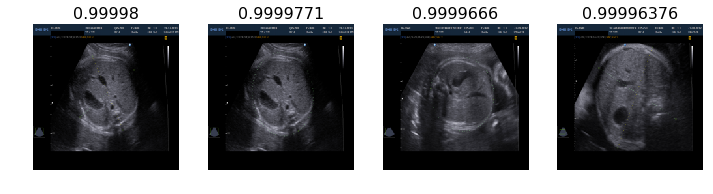

In [22]:
imr.plot_most_correct(0)

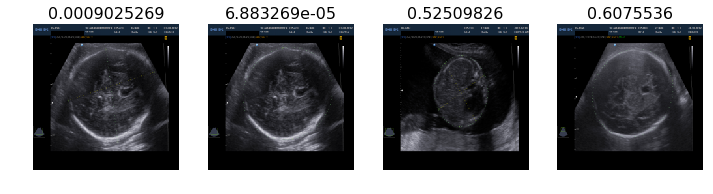

In [23]:
imr.plot_most_uncertain(0)

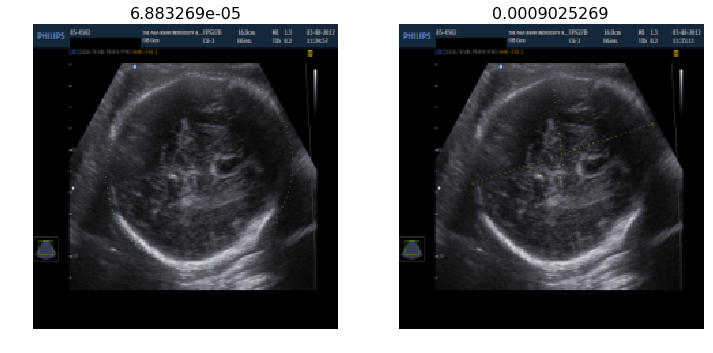

In [24]:
imr.plot_most_incorrect(0)

# Exploring test Set

In [25]:
log_testpreds = learn.predict(is_test=True)
probs_test = np.exp(log_testpreds)
probs_test.shape

(427, 9)

In [26]:
fns_test = [PATH + i for i in data.test_ds.fnames]

In [27]:
df_data = []
for prob, val_y, fn in zip(probs_test, data.val_y, fns_test):
    df_data.append({"BestProp": prob.max(), "BestProbClass": prob.argmax(), "Actual": val_y, "Filename": fn})
df = pd.DataFrame(df_data)
df.columns, df.index

(Index(['Actual', 'BestProbClass', 'BestProp', 'Filename'], dtype='object'),
 RangeIndex(start=0, stop=324, step=1))

In [28]:
df.to_csv('data/BMP_Multi/testtruth.csv')